In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-8143xcv3
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-8143xcv3
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 730b907b4d45a4713cbc425cbf224c46089fd514
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import multiprocessing
from pathlib import Path
import concurrent.futures
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, ToTensor
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray"
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database"

In [7]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [8]:
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [9]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))

In [10]:
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [11]:
class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 701388.63it/s]


In [12]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [13]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 24645/24645 [00:19<00:00, 1236.18it/s]

                 Class  Black & White  Colored
0               Normal          10192        0
1         Lung_Opacity           6012        0
2      Viral Pneumonia           1205      140
3                COVID           3616        0
4  Bacterial Pneumonia           2637      143
5         Tuberculosis            308      392


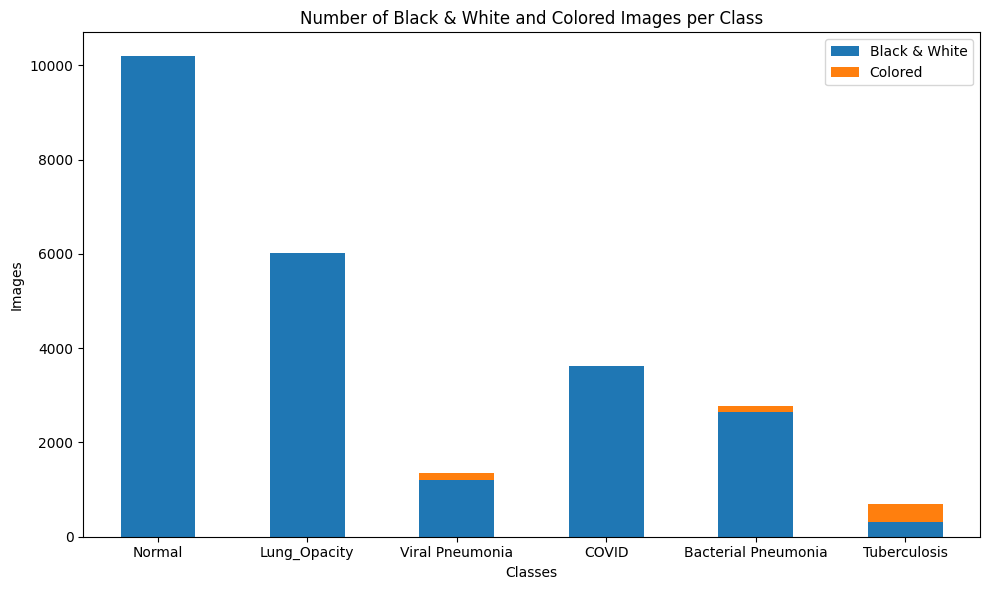

In [14]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 6/6 [00:00<00:00, 167.46it/s]


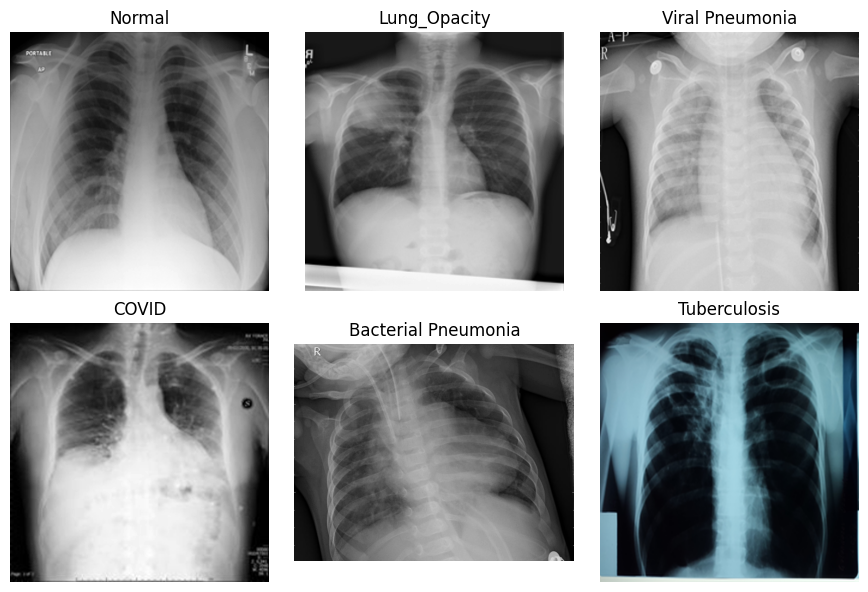

In [15]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 6/6 [00:18<00:00,  3.15s/it]


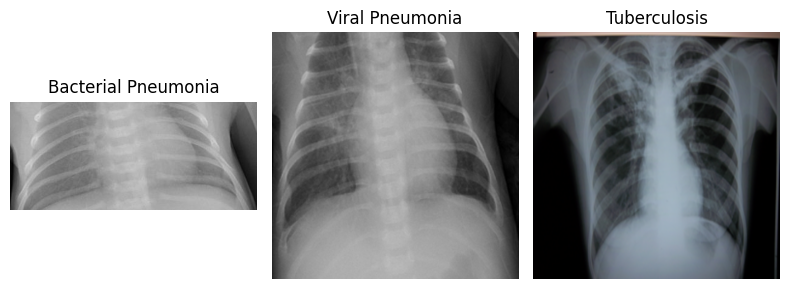

In [16]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [17]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [18]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.1,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2222,
                                                                    random_state=42,
                                                                    stratify=train_labels)

In [19]:
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = class_names

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 17251
Total Validation Samples: 2465
Total Test Samples: 4929

Percentage of Split:
Train: 70.00%
Validation: 10.00%
Test: 20.00%

Class Distribution:
                     Train Samples  Validation Samples  Test Samples
Normal                        1946                 278           556
Lung_Opacity                  2531                 362           723
Viral Pneumonia               4209                 601          1202
COVID                         7134                1019          2039
Bacterial Pneumonia            490                  70           140
Tuberculosis                   941                 135           269


In [20]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pil_img = Image.fromarray(img)
        
        transformed_img = self.transform(pil_img)

        label = self.img_labels[index]
        return transformed_img, label

In [21]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [22]:
model = timm.create_model('pit_ti_224', pretrained=True)

model.head = torch.nn.Linear(model.head.in_features, num_classes)

model.to(device)

summary(model, (3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 6]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [23]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [25]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_loss = total_loss / len(train_loader)
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time

    average_loss = total_loss / len(val_loader)
    
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.80it/s]


Metrics: loss: 0.4369, accuracy: 0.8357, precision: 0.8330, recall: 0.8357, f1_score: 0.8329, specificity: 0.8325, sensitivity: 0.9671, mcc: 0.7739, auc: 0.9596


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.12it/s]


Metrics: loss: 0.4238, accuracy: 0.8385, precision: 0.8601, recall: 0.8385, f1_score: 0.8400, specificity: 0.8957, sensitivity: 0.9721, mcc: 0.7889, auc: 0.9804


Training Model - Epoch [2/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.82it/s]


Metrics: loss: 0.2544, accuracy: 0.9055, precision: 0.9049, recall: 0.9055, f1_score: 0.9049, specificity: 0.8936, sensitivity: 0.9823, mcc: 0.8705, auc: 0.9843


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.06it/s]


Metrics: loss: 0.2301, accuracy: 0.9132, precision: 0.9161, recall: 0.9132, f1_score: 0.9134, specificity: 0.8489, sensitivity: 0.9936, mcc: 0.8815, auc: 0.9872


Training Model - Epoch [3/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.81it/s]


Metrics: loss: 0.2056, accuracy: 0.9224, precision: 0.9221, recall: 0.9224, f1_score: 0.9221, specificity: 0.9116, sensitivity: 0.9858, mcc: 0.8938, auc: 0.9885


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.07it/s]


Metrics: loss: 0.2859, accuracy: 0.8917, precision: 0.9053, recall: 0.8917, f1_score: 0.8942, specificity: 0.7662, sensitivity: 0.9963, mcc: 0.8554, auc: 0.9836


Training Model - Epoch [4/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.78it/s]


Metrics: loss: 0.1682, accuracy: 0.9383, precision: 0.9381, recall: 0.9383, f1_score: 0.9381, specificity: 0.9214, sensitivity: 0.9882, mcc: 0.9156, auc: 0.9919


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.08it/s]


Metrics: loss: 0.2378, accuracy: 0.9103, precision: 0.9156, recall: 0.9103, f1_score: 0.9107, specificity: 0.8094, sensitivity: 0.9945, mcc: 0.8777, auc: 0.9885


Training Model - Epoch [5/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.86it/s]


Metrics: loss: 0.1423, accuracy: 0.9482, precision: 0.9481, recall: 0.9482, f1_score: 0.9481, specificity: 0.9332, sensitivity: 0.9901, mcc: 0.9291, auc: 0.9938


Validating Model: 100%|██████████| 155/155 [00:15<00:00, 10.29it/s]


Metrics: loss: 0.2362, accuracy: 0.9071, precision: 0.9099, recall: 0.9071, f1_score: 0.9070, specificity: 0.8849, sensitivity: 0.9867, mcc: 0.8731, auc: 0.9884


Training Model - Epoch [6/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.84it/s]


Metrics: loss: 0.1276, accuracy: 0.9524, precision: 0.9523, recall: 0.9524, f1_score: 0.9523, specificity: 0.9430, sensitivity: 0.9926, mcc: 0.9349, auc: 0.9953


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.35it/s]


Metrics: loss: 0.2792, accuracy: 0.9018, precision: 0.9067, recall: 0.9018, f1_score: 0.9012, specificity: 0.9065, sensitivity: 0.9936, mcc: 0.8661, auc: 0.9908


Training Model - Epoch [7/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.86it/s]


Metrics: loss: 0.1036, accuracy: 0.9638, precision: 0.9637, recall: 0.9638, f1_score: 0.9637, specificity: 0.9538, sensitivity: 0.9936, mcc: 0.9504, auc: 0.9967


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.46it/s]


Metrics: loss: 0.2608, accuracy: 0.9103, precision: 0.9140, recall: 0.9103, f1_score: 0.9088, specificity: 0.9784, sensitivity: 0.9771, mcc: 0.8778, auc: 0.9915


Training Model - Epoch [8/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.77it/s]


Metrics: loss: 0.0904, accuracy: 0.9678, precision: 0.9678, recall: 0.9678, f1_score: 0.9678, specificity: 0.9635, sensitivity: 0.9950, mcc: 0.9560, auc: 0.9976


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.58it/s]


Metrics: loss: 0.2168, accuracy: 0.9270, precision: 0.9276, recall: 0.9270, f1_score: 0.9268, specificity: 0.9173, sensitivity: 0.9936, mcc: 0.9001, auc: 0.9929


Training Model - Epoch [9/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.84it/s]


Metrics: loss: 0.0798, accuracy: 0.9721, precision: 0.9720, recall: 0.9721, f1_score: 0.9720, specificity: 0.9697, sensitivity: 0.9958, mcc: 0.9618, auc: 0.9979


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.05it/s]


Metrics: loss: 0.2322, accuracy: 0.9241, precision: 0.9269, recall: 0.9241, f1_score: 0.9241, specificity: 0.9137, sensitivity: 0.9945, mcc: 0.8970, auc: 0.9907


Training Model - Epoch [10/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.78it/s]


Metrics: loss: 0.0711, accuracy: 0.9748, precision: 0.9748, recall: 0.9748, f1_score: 0.9748, specificity: 0.9656, sensitivity: 0.9951, mcc: 0.9655, auc: 0.9983


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.09it/s]


Metrics: loss: 0.2911, accuracy: 0.9136, precision: 0.9165, recall: 0.9136, f1_score: 0.9122, specificity: 0.9460, sensitivity: 0.9909, mcc: 0.8829, auc: 0.9917


Training Model - Epoch [11/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.81it/s]


Metrics: loss: 0.0674, accuracy: 0.9737, precision: 0.9737, recall: 0.9737, f1_score: 0.9737, specificity: 0.9681, sensitivity: 0.9955, mcc: 0.9641, auc: 0.9985


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.12it/s]


Metrics: loss: 0.3201, accuracy: 0.9051, precision: 0.9108, recall: 0.9051, f1_score: 0.9055, specificity: 0.7950, sensitivity: 0.9982, mcc: 0.8706, auc: 0.9897


Training Model - Epoch [12/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.84it/s]


Metrics: loss: 0.0544, accuracy: 0.9814, precision: 0.9814, recall: 0.9814, f1_score: 0.9814, specificity: 0.9753, sensitivity: 0.9973, mcc: 0.9746, auc: 0.9989


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.29it/s]


Metrics: loss: 0.2581, accuracy: 0.9172, precision: 0.9171, recall: 0.9172, f1_score: 0.9168, specificity: 0.9317, sensitivity: 0.9867, mcc: 0.8868, auc: 0.9910


Training Model - Epoch [13/25]: 100%|██████████| 1079/1079 [01:51<00:00,  9.69it/s]


Metrics: loss: 0.0540, accuracy: 0.9809, precision: 0.9809, recall: 0.9809, f1_score: 0.9809, specificity: 0.9769, sensitivity: 0.9970, mcc: 0.9739, auc: 0.9990


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.44it/s]


Metrics: loss: 0.2413, accuracy: 0.9343, precision: 0.9347, recall: 0.9343, f1_score: 0.9341, specificity: 0.9353, sensitivity: 0.9945, mcc: 0.9101, auc: 0.9931


Training Model - Epoch [14/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.87it/s]


Metrics: loss: 0.0540, accuracy: 0.9815, precision: 0.9815, recall: 0.9815, f1_score: 0.9815, specificity: 0.9789, sensitivity: 0.9973, mcc: 0.9747, auc: 0.9990


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.44it/s]


Metrics: loss: 0.3303, accuracy: 0.9189, precision: 0.9191, recall: 0.9189, f1_score: 0.9181, specificity: 0.9424, sensitivity: 0.9790, mcc: 0.8890, auc: 0.9905


Training Model - Epoch [15/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.88it/s]


Metrics: loss: 0.0469, accuracy: 0.9833, precision: 0.9833, recall: 0.9833, f1_score: 0.9833, specificity: 0.9784, sensitivity: 0.9972, mcc: 0.9772, auc: 0.9992


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.40it/s]


Metrics: loss: 0.3215, accuracy: 0.9193, precision: 0.9250, recall: 0.9193, f1_score: 0.9197, specificity: 0.8237, sensitivity: 0.9986, mcc: 0.8902, auc: 0.9917


Training Model - Epoch [16/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.86it/s]


Metrics: loss: 0.0432, accuracy: 0.9846, precision: 0.9846, recall: 0.9846, f1_score: 0.9846, specificity: 0.9789, sensitivity: 0.9976, mcc: 0.9789, auc: 0.9994


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.21it/s]


Metrics: loss: 0.3508, accuracy: 0.9083, precision: 0.9099, recall: 0.9083, f1_score: 0.9072, specificity: 0.9856, sensitivity: 0.9794, mcc: 0.8746, auc: 0.9905


Training Model - Epoch [17/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.78it/s]


Metrics: loss: 0.0413, accuracy: 0.9850, precision: 0.9850, recall: 0.9850, f1_score: 0.9850, specificity: 0.9805, sensitivity: 0.9971, mcc: 0.9795, auc: 0.9994


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.12it/s]


Metrics: loss: 0.2888, accuracy: 0.9164, precision: 0.9183, recall: 0.9164, f1_score: 0.9160, specificity: 0.9748, sensitivity: 0.9799, mcc: 0.8861, auc: 0.9922


Training Model - Epoch [18/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.73it/s]


Metrics: loss: 0.0372, accuracy: 0.9866, precision: 0.9865, recall: 0.9866, f1_score: 0.9865, specificity: 0.9836, sensitivity: 0.9977, mcc: 0.9816, auc: 0.9995


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.05it/s]


Metrics: loss: 0.3863, accuracy: 0.9026, precision: 0.9120, recall: 0.9026, f1_score: 0.9048, specificity: 0.9424, sensitivity: 0.9909, mcc: 0.8701, auc: 0.9916


Training Model - Epoch [19/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.77it/s]


Metrics: loss: 0.0379, accuracy: 0.9868, precision: 0.9868, recall: 0.9868, f1_score: 0.9868, specificity: 0.9872, sensitivity: 0.9978, mcc: 0.9820, auc: 0.9995


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.23it/s]


Metrics: loss: 0.2885, accuracy: 0.9201, precision: 0.9209, recall: 0.9201, f1_score: 0.9197, specificity: 0.9712, sensitivity: 0.9858, mcc: 0.8906, auc: 0.9930


Training Model - Epoch [20/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.87it/s]


Metrics: loss: 0.0392, accuracy: 0.9873, precision: 0.9873, recall: 0.9873, f1_score: 0.9873, specificity: 0.9856, sensitivity: 0.9976, mcc: 0.9826, auc: 0.9994


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.45it/s]


Metrics: loss: 0.3148, accuracy: 0.9225, precision: 0.9236, recall: 0.9225, f1_score: 0.9225, specificity: 0.9317, sensitivity: 0.9927, mcc: 0.8940, auc: 0.9918


Training Model - Epoch [21/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.88it/s]


Metrics: loss: 0.0319, accuracy: 0.9882, precision: 0.9882, recall: 0.9882, f1_score: 0.9882, specificity: 0.9892, sensitivity: 0.9988, mcc: 0.9839, auc: 0.9996


Validating Model: 100%|██████████| 155/155 [00:13<00:00, 11.38it/s]


Metrics: loss: 0.3125, accuracy: 0.9274, precision: 0.9287, recall: 0.9274, f1_score: 0.9269, specificity: 0.9173, sensitivity: 0.9941, mcc: 0.9011, auc: 0.9916


Training Model - Epoch [22/25]: 100%|██████████| 1079/1079 [01:49<00:00,  9.83it/s]


Metrics: loss: 0.0323, accuracy: 0.9889, precision: 0.9889, recall: 0.9889, f1_score: 0.9889, specificity: 0.9825, sensitivity: 0.9978, mcc: 0.9849, auc: 0.9995


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.10it/s]


Metrics: loss: 0.4805, accuracy: 0.9002, precision: 0.9045, recall: 0.9002, f1_score: 0.8993, specificity: 0.9388, sensitivity: 0.9945, mcc: 0.8631, auc: 0.9908


Training Model - Epoch [23/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.81it/s]


Metrics: loss: 0.0398, accuracy: 0.9858, precision: 0.9858, recall: 0.9858, f1_score: 0.9858, specificity: 0.9815, sensitivity: 0.9976, mcc: 0.9806, auc: 0.9995


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.20it/s]


Metrics: loss: 0.3412, accuracy: 0.9148, precision: 0.9153, recall: 0.9148, f1_score: 0.9143, specificity: 0.9281, sensitivity: 0.9895, mcc: 0.8834, auc: 0.9912


Training Model - Epoch [24/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.75it/s]


Metrics: loss: 0.0295, accuracy: 0.9901, precision: 0.9901, recall: 0.9901, f1_score: 0.9901, specificity: 0.9856, sensitivity: 0.9984, mcc: 0.9864, auc: 0.9997


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.04it/s]


Metrics: loss: 0.2865, accuracy: 0.9254, precision: 0.9251, recall: 0.9254, f1_score: 0.9252, specificity: 0.9532, sensitivity: 0.9922, mcc: 0.8979, auc: 0.9919


Training Model - Epoch [25/25]: 100%|██████████| 1079/1079 [01:50<00:00,  9.77it/s]


Metrics: loss: 0.0289, accuracy: 0.9906, precision: 0.9906, recall: 0.9906, f1_score: 0.9906, specificity: 0.9892, sensitivity: 0.9984, mcc: 0.9872, auc: 0.9996


Validating Model: 100%|██████████| 155/155 [00:12<00:00, 12.11it/s]

Metrics: loss: 0.3625, accuracy: 0.9112, precision: 0.9129, recall: 0.9112, f1_score: 0.9106, specificity: 0.9245, sensitivity: 0.9899, mcc: 0.8787, auc: 0.9905
Total Training Time: 0:45:49.288507
Total Validation Time: 0:05:29.304877
Average Training Time per Epoch: 0:01:49.971540
Average Validation Time per Epoch: 0:00:13.172195


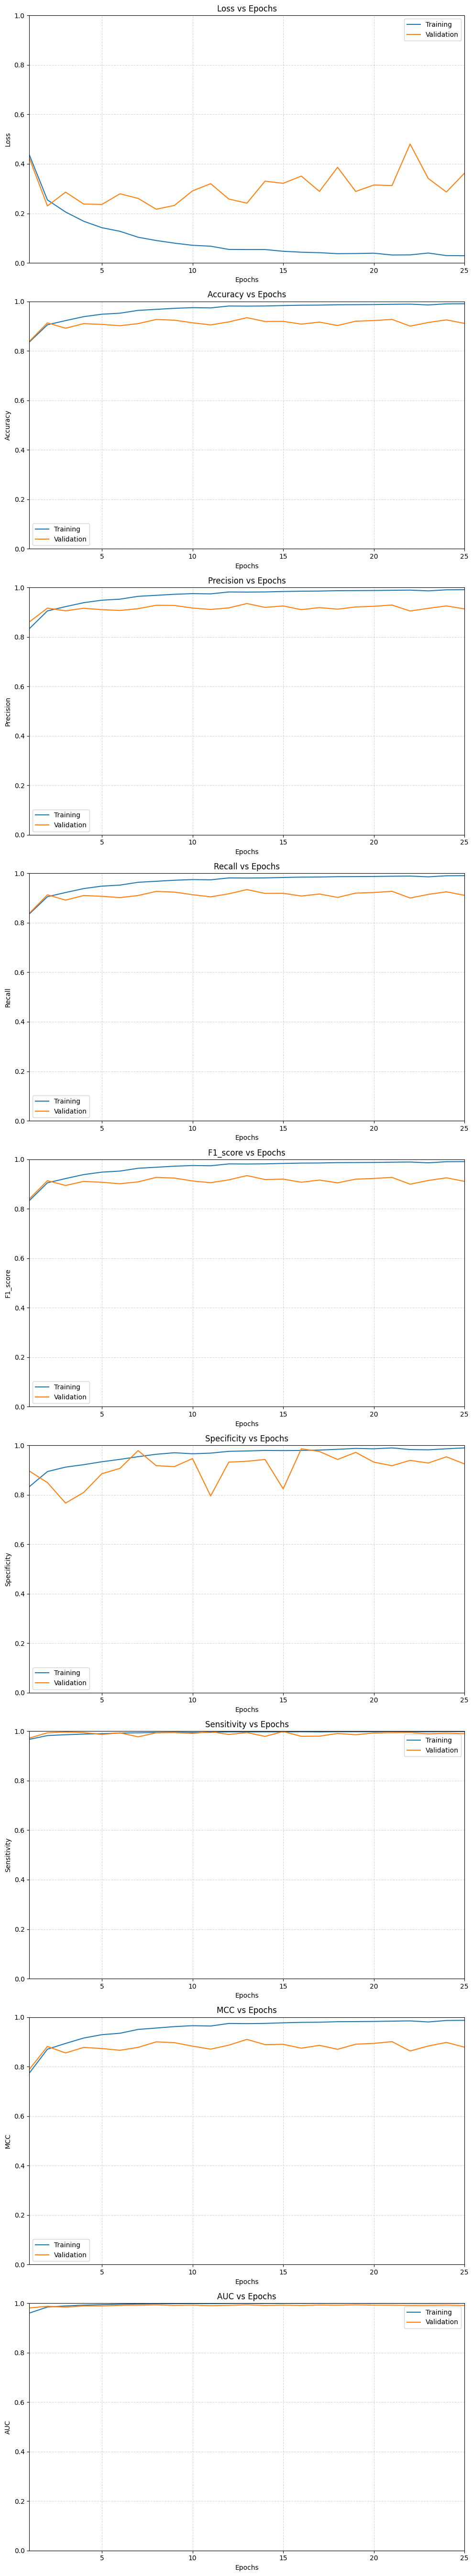

In [26]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [27]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 309/309 [00:27<00:00, 11.32it/s]

Metrics: loss: 0.3502, accuracy: 0.9150, precision: 0.9169, recall: 0.9150, f1_score: 0.9143, specificity: 0.9119, sensitivity: 0.9895, mcc: 0.8839, auc: 0.9909


In [28]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.9168    0.9119    0.9143       556
              COVID     0.9740    0.9336    0.9534       723
       Lung_Opacity     0.9365    0.8344    0.8825      1202
             Normal     0.8895    0.9711    0.9285      2039
       Tuberculosis     0.9923    0.9214    0.9556       140
    Viral Pneumonia     0.8438    0.8030    0.8229       269

           accuracy                         0.9150      4929
          macro avg     0.9255    0.8959    0.9095      4929
       weighted avg     0.9169    0.9150    0.9143      4929

There were 419 errors in 4929 tests for an accuracy of  91.50


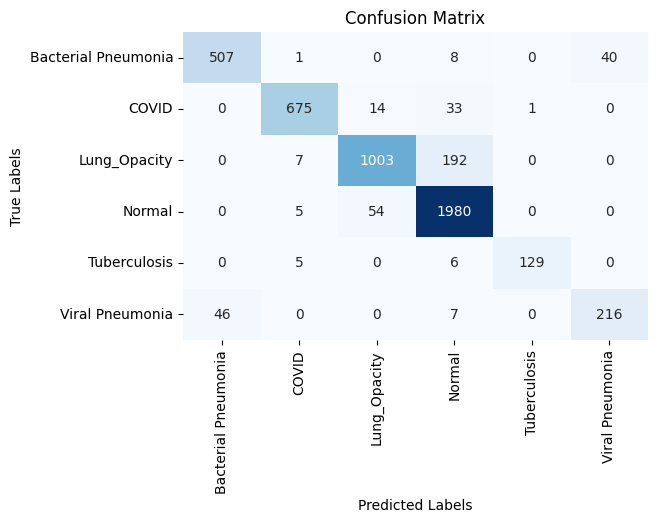

In [29]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()